# Analysis Code: Attractors during task

In [55]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.integrate as integrate

sns.set(style="white")
import os
from glob import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler

## load study 1

In [56]:
# load Essen timeseries data and scrub resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5
all_ts = []
root_dir = 'data/ex_timeseries/'
for f in glob(root_dir + 'essen-*.tsv'):  # change to bochum-*.tsv for replication with the Bochum dataset
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))
    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
len(all_ts)

perc. scrubbed: 0.5103448275862069
perc. scrubbed: 0.503448275862069


47

In [57]:
# comopute the negative precision matrix via nilearn
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='precision',  vectorize=False, discard_diagonal=False) # uses Ledoit-Wolf estimator
correlation_measure.fit_transform(all_ts)
J = -1 * correlation_measure.mean_

In [58]:
def compute_W_from_J(J, num_attractors=None):
    if num_attractors is None:
        num_attractors = J.shape[0]
    # Eigenvalue decomposition of J
    eigenvalues, eigenvectors = np.linalg.eigh(J)
    # Sort eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Select the first `num_hidden_nodes` eigenvalues and eigenvectors
    selected_eigenvalues = eigenvalues[:num_attractors]
    selected_eigenvectors = eigenvectors[:, :num_attractors]
    # Compute the weight matrix W
    W = selected_eigenvectors * np.sqrt(-selected_eigenvalues)
    return W

## Load task-based data

In [59]:
# load taks-based data and scrub resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

timeseries = []
events_heat = []
events_pain = []
events_rating = []

_TR_ = 2.0  # seconds

for sub in range(1, 33):
    sub_pad = f'{sub + 1:02}'

    fd_path = 'data/ex_timeseries_task/sub-' + sub_pad + '_FD.txt'
    fd = pd.read_csv(fd_path).values.flatten()
    fd = np.hstack(([0], fd))

    ts_path = 'data/ex_timeseries_task/sub-' + sub_pad + '_ts.txt'
    ts = pd.read_csv(ts_path, sep='\t').iloc[:, 1:].values

    events_path = 'data/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-01_events.tsv'
    event = pd.read_csv(events_path, sep='\t')
    ratings = event['ratings'].values
    event_heatpain = event[~ np.isnan(event['temperature'])].copy()  # remove rating blocks, only retain heat pain blocks
    event_heatpain['ratings'] = ratings[~ np.isnan(ratings)] 

    event_heat = event_heatpain[event_heatpain['ratings']<100]
    event_pain = event_heatpain[event_heatpain['ratings']>=100]
    event_rating = event[np.isnan(event['temperature'])].copy()

    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd > _fd_thr) / len(fd) < _perc_scrub_thr:
        ts[fd >= _fd_thr] = np.nan
    else:  
        print(sub, 'perc. scrubbed:', np.sum(fd > _fd_thr) / len(fd))
        continue

    timeseries.append(ts)
    events_heat.append(event_heat)
    events_pain.append(event_pain)
    events_rating.append(event_rating)


6 perc. scrubbed: 0.8133971291866029
10 perc. scrubbed: 0.5741626794258373
28 perc. scrubbed: 0.6267942583732058
29 perc. scrubbed: 0.7081339712918661


In [191]:
len(timeseries)

28

In [84]:
#1st level analysis

from tqdm import tqdm
from nilearn.glm.first_level import compute_regressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

J = -1 * correlation_measure.mean_
W = compute_W_from_J(J)

all_proj = []
models = {}

for sub in tqdm(range(len(timeseries))):
    models[sub] = {}

    # attractor timeseries
    proj = W.T @ timeseries[sub].T
    all_proj.append(proj)

    # HRF-convolved EV from the events: heat
    ev = events_heat[sub][['onset', 'duration', 'ratings']].copy()
    ev.loc[:, 'ratings'] = 1 
    hrf_regressor_heat = compute_regressor(ev.values.transpose(),
                                    hrf_model='spm',
                                    frame_times=np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_))[0].flatten()

    # parametric modulation with heat rating
    ev = events_heat[sub][['onset', 'duration', 'ratings']].copy()
    # center the ratings
    ev.loc[:, 'ratings'] = (ev['ratings'] - np.mean(ev['ratings']))/100
    hrf_regressor_heatint = compute_regressor(ev.values.transpose(),
                                    hrf_model='spm',
                                    frame_times=np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_))[0].flatten()
    
    # HRF-convolved EV from the events: pain
    ev = events_pain[sub][['onset', 'duration', 'ratings']].copy()
    ev.loc[:, 'ratings'] = 1 
    hrf_regressor_pain = compute_regressor(ev.values.transpose(),
                                    hrf_model='spm',
                                    frame_times=np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_))[0].flatten()

    # parametric modulation with pain rating    
    ev = events_pain[sub][['onset', 'duration', 'ratings']].copy()
    # center the ratings
    ev.loc[:, 'ratings'] = (ev['ratings'] - np.mean(ev['ratings']))/100
    hrf_regressor_painint = compute_regressor(ev.values.transpose() ,
                                    hrf_model='spm',
                                    frame_times=np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_))[0].flatten()
    
    # HRF-convolved EV from the events: rating events
    ev = events_rating[sub][['onset', 'duration', 'ratings']].copy()
    ev.loc[:, 'ratings'] = 1 
    hrf_regressor_rating = compute_regressor(ev.values.transpose(),
                                    hrf_model='spm',
                                    frame_times=np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_))[0].flatten()

    # plot regressors on a single plot
    #plt.figure(figsize=(10, 6))
    #plt.plot(hrf_regressor_heat, label='HRF_Regressor_Heat')
    #plt.plot(hrf_regressor_heatint, label='HRF_Regressor_HeatInt')
    #plt.plot(hrf_regressor_pain, label='HRF_Regressor_Pain')
    #plt.plot(hrf_regressor_painint, label='HRF_Regressor_PainInt')
    #plt.plot(hrf_regressor_rating, label='HRF_Regressor_Rating')
    #plt.legend()
    #plt.show()

    #plot attractor activity
    #plt.figure(figsize=(10, 6))
    #plt.plot(proj[sub, :])
    #plt.show()
    
    # fit 1st level model with statsmodels
    for attr in range(W.shape[0]):

        # Create a DataFrame for the model
        HRF_df = pd.DataFrame({
            'Attractor_Activity': proj[attr, :],
            'HRF_Regressor_Heat': hrf_regressor_heat,
            'HRF_Regressor_HeatInt': hrf_regressor_heatint,
            'HRF_Regressor_Pain': hrf_regressor_pain,  
            'HRF_Regressor_PainInt': hrf_regressor_painint, 
            'HRF_Regressor_Rating': hrf_regressor_rating,
        })

        data.dropna(inplace=True)

        # Define the formula for the model
        formula = 'Attractor_Activity ~ HRF_Regressor_Heat + HRF_Regressor_HeatInt + HRF_Regressor_Pain + HRF_Regressor_PainInt + HRF_Regressor_Rating'
        # Fit the model
        model = smf.ols(formula, data=HRF_df).fit()

        # hack in differece contrast for heat and pain
        params = model.params.copy()
        params['Pain>Heat'] = params['HRF_Regressor_Pain'] - params['HRF_Regressor_Heat']
        # Get the parameter estimates
        models[sub][attr] = params     


  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


## Second level analysis

In [85]:
from scipy.stats import wilcoxon

second_level_results = {}

for attr in range(W.shape[0]):
    second_level_results[attr] = {}
    # for each event type
    for event_type in models[0][attr].index:
        # skip Intercept
        if event_type == 'Intercept':
            continue
        betas = np.array([models[sub][attr][event_type] for sub in range(len(models))])
        statistic, p_value = wilcoxon(betas)
        second_level_results[attr][event_type] = {'statistic': statistic, 'p_value': p_value}

## Plotting the results

** HRF_Regressor_Heat, Attractor 2
Attractor                                                                                                                Event Type                Statistic            p-value              Mean Beta           
2                    HRF_Regressor_Heat        54.0                 0.0003418475389480591 1.1946777436036105  
2                    HRF_Regressor_HeatInt     156.0                0.2945980280637741   3.861890296886556   
2                    HRF_Regressor_Pain        31.0                 0.00014707923522242587 1.278951031272071   
2                    HRF_Regressor_PainInt     147.0                0.312950675522914    -1.8131476377402103 
2                    HRF_Regressor_Rating      181.0                0.6295278295874596   -0.32964787978591625
2                    Pain>Heat                 174.0                0.5221440717577934   0.08427328766846046 
* Top 5 highest weights:
PUT_p: 0.1981496019178994
PSMcor_p: 0.20707563086953565
MOTnet_am: 

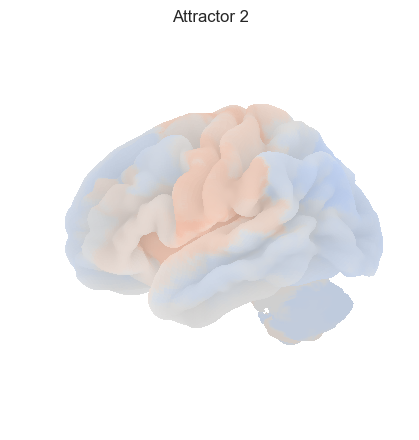

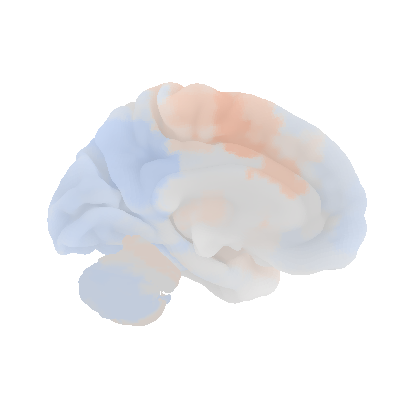

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_54834/3958049489.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),


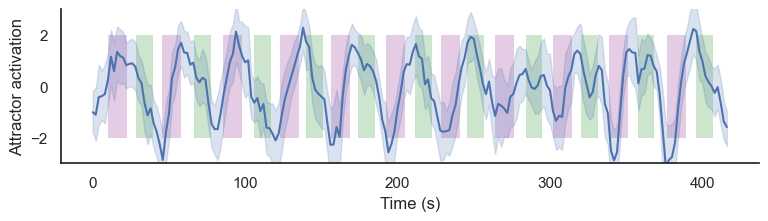

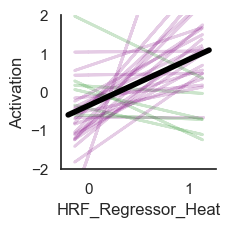

** HRF_Regressor_HeatInt, Attractor 90
Attractor                                                                                                                Event Type                Statistic            p-value              Mean Beta           
90                   HRF_Regressor_Heat        147.0                0.20980393886566162  0.17888921402396532 
90                   HRF_Regressor_HeatInt     77.0                 0.003160528838634491 5.316791290590619   
90                   HRF_Regressor_Pain        177.0                0.7731171162909528   -0.12254378568820427
90                   HRF_Regressor_PainInt     172.0                0.6829616948348547   -0.2777262975350343 
90                   HRF_Regressor_Rating      202.0                0.9910601079463959   0.07460427501825548 
90                   Pain>Heat                 109.0                0.03170907497406006  -0.3014329997121696 
* Top 5 highest weights:
FUSgyr_vl: 0.6194357918490273
MOTnet_m: 0.6233154003929536
R_MTgyr

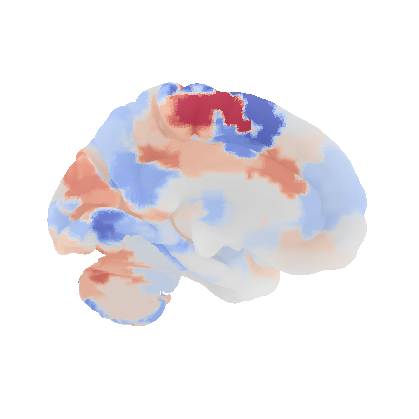

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_54834/3958049489.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),


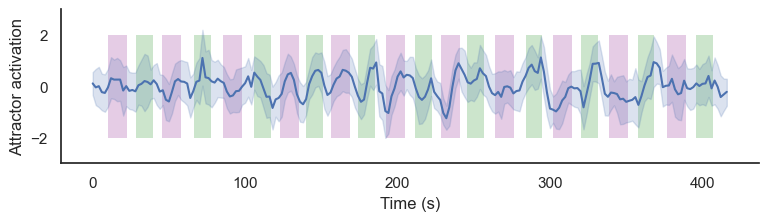

** HRF_Regressor_Pain, Attractor 2
Attractor                                                                                                                Event Type                Statistic            p-value              Mean Beta           
2                    HRF_Regressor_Heat        54.0                 0.0003418475389480591 1.1946777436036105  
2                    HRF_Regressor_HeatInt     156.0                0.2945980280637741   3.861890296886556   
2                    HRF_Regressor_Pain        31.0                 0.00014707923522242587 1.278951031272071   
2                    HRF_Regressor_PainInt     147.0                0.312950675522914    -1.8131476377402103 
2                    HRF_Regressor_Rating      181.0                0.6295278295874596   -0.32964787978591625
2                    Pain>Heat                 174.0                0.5221440717577934   0.08427328766846046 
* Top 5 highest weights:
PUT_p: 0.1981496019178994
PSMcor_p: 0.20707563086953565
MOTnet_am: 

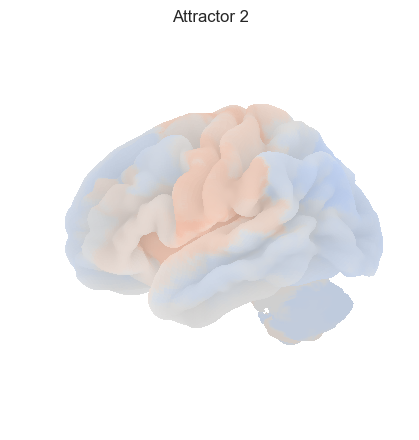

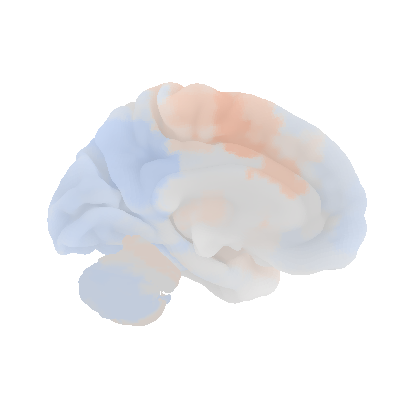

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_54834/3958049489.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),


** HRF_Regressor_PainInt, Attractor 103
Attractor                                                                                                                Event Type                Statistic            p-value              Mean Beta           
103                  HRF_Regressor_Heat        132.0                0.10925160348415375  -0.25616076026645523
103                  HRF_Regressor_HeatInt     178.0                0.5823858305811882   4.15750011573819    
103                  HRF_Regressor_Pain        53.0                 0.0010854025603301046 -0.4961819664621836 
103                  HRF_Regressor_PainInt     81.0                 0.009467354390313695 -2.92564712963715   
103                  HRF_Regressor_Rating      181.0                0.6295278295874596   -0.0794370088554678 
103                  Pain>Heat                 127.0                0.08565542846918106  -0.2400212061957284 
* Top 5 highest weights:
L_DVIS_v: 0.7762815729274606
AINS_pd: 0.8781238495445042
PCcor: 

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_54834/3958049489.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),


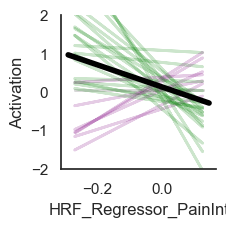

** HRF_Regressor_Rating, Attractor 17
Attractor                                                                                                                Event Type                Statistic            p-value              Mean Beta           
17                   HRF_Regressor_Heat        119.0                0.05638675391674042  0.643322703690523   
17                   HRF_Regressor_HeatInt     147.0                0.20980393886566162  -18.336431042735057 
17                   HRF_Regressor_Pain        85.0                 0.012468499505409928 0.5430887150496676  
17                   HRF_Regressor_PainInt     108.0                0.05165174631921653  2.4847312306292038  
17                   HRF_Regressor_Rating      21.0                 3.330409526824951e-06 -1.1800579128176203 
17                   Pain>Heat                 203.0                1.0                  -0.1002339886408553 
* Top 5 highest weights:
AMY: 0.3396656633318344
L_IFsul: 0.3482554843117161
R_IFsul: 0.374

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_54834/3958049489.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),


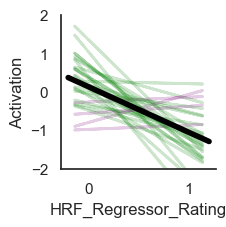

** Pain>Heat, Attractor 71
Attractor                                                                                                                Event Type                Statistic            p-value              Mean Beta           
71                   HRF_Regressor_Heat        185.0                0.6947018131613731   0.0375756476070536  
71                   HRF_Regressor_HeatInt     128.0                0.09002415090799332  2.2389596781921175  
71                   HRF_Regressor_Pain        112.0                0.06432437111397585  -0.31845981807439666
71                   HRF_Regressor_PainInt     118.0                0.08804999262777848  1.1734473829833796  
71                   HRF_Regressor_Rating      159.0                0.3272097110748291   0.195936787406258   
71                   Pain>Heat                 88.0                 0.007629185914993286 -0.3560354656814502 
* Top 5 highest weights:
L_SFsul_a: 0.6840978312177896
IMsul: 0.6876313846004833
l_PCsul: 0.73566564422

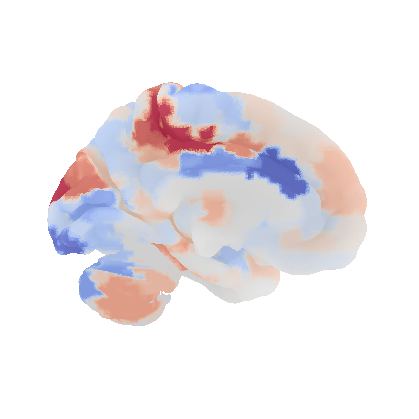

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_54834/3958049489.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),


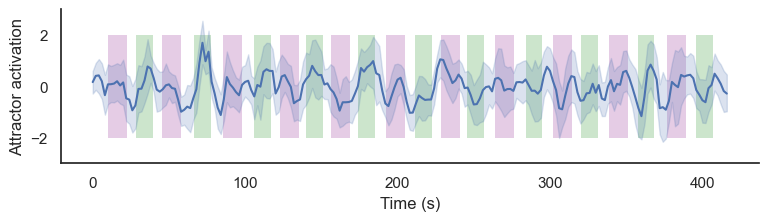

In [190]:
from nilearn import datasets, surface, plotting
from matplotlib.patches import Rectangle
from connattractor import network
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

mist_regions = pd.read_csv('data/MIST122_relabeled.tsv', sep='\t')
mist_regions.columns = ['label', 'MIST_index', 'region', 'module']
mist_mapper=mist_regions[['label', 'region']]
mist_mapper.set_index('region', inplace=True)

fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                    np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)

for event_type in second_level_results[attr].keys():
    # Set the number of attractors to plot
    k = 1

    # find the k attractors with the lowest p-values
    p_values = []
    for attr in range(W.shape[0]):
        p_value = second_level_results[attr][event_type]['p_value']
        p_values.append((p_value, attr))
    p_values.sort()

    for i in range(k):
        min_p_values, min_attr = p_values[i]
        print('===========================================')
        print(f'** {event_type}, Attractor {min_attr}')
        print(f'{"Attractor":<120} {"Event Type":<25} {"Statistic":<20} {"p-value":<20} {"Mean Beta":<20}')
        for event_types in second_level_results[attr].keys():
            statistics = second_level_results[min_attr][event_types]['statistic']
            mean_betas = np.mean([models[sub][min_attr][event_types] for sub in range(len(models))])
            p_values = second_level_results[min_attr][event_types]['p_value']
            print(f'{min_attr:<20} {event_types:<25} {statistics:<20} {p_values:<20} {mean_betas:<20}')

        # print out the top 5 lowest and highest regions, based on mist_mapper
        # Get the mean activation for each region

        mean_beta = np.mean([models[sub][min_attr][event_type] for sub in range(len(models))])
        
        sign = 1
        region_indices = np.argsort(sign * W[:, min_attr])
        top_5_lowest = mist_regions.loc[region_indices[:5], 'region']
        top_5_highest = mist_regions.loc[region_indices[-5:], 'region']
        print('* Top 5 highest weights:')
        for region in region_indices[-5:]:
            print(f'{mist_regions.loc[region, "region"]}: {W[region, min_attr]}')
        print('* Top 5 lowest weights:')
        for region in region_indices[:5]:
            print(f'{mist_regions.loc[region, "region"]}: {W[region, min_attr]}')


        # surface plot
        #if event_type == 'Rating':
        #    img = network.State(sign * W[:,min_attr]).to_Nifti1Image() # visualization hack
        #else:
        img = network.State(sign * W[:,min_attr]).to_Nifti1Image()
        texture = surface.vol_to_surf(img, surf)
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, 
                                          hemi='left', colorbar=False, cmap='coolwarm', 
                                          threshold=0, symmetric_cbar=True, vmax=0.6,
                                          title='Attractor {}'.format(min_attr))

        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, 
                                          hemi='right', colorbar=False, cmap='coolwarm', 
                                          threshold=0, symmetric_cbar=True, vmax=0.6)
        plt.show()

        fig, ax = plt.subplots(figsize=(9, 2))
        # blocks
        for j in events_heat[-1].index:
            ax.add_patch(Rectangle((events_heat[-1]['onset'][j], -2), 
                                        events_heat[-1]['duration'][j],
                                        4, 
                                        alpha=0.2,
                                        linewidth=0,
                                        color='purple'))
            
        for j in events_pain[-1].index:
            ax.add_patch(Rectangle((events_pain[-1]['onset'][j], -2), 
                                        events_pain[-1]['duration'][j],
                                        4, 
                                        alpha=0.2,
                                        linewidth=0,
                                        color='purple'))

        for j in events_rating[-1].index:
            ax.add_patch(Rectangle((events_rating[-1]['onset'][j], -2), 
                                        events_rating[-1]['duration'][j],
                                        4, 
                                        alpha=0.2,
                                        linewidth=0,
                                        color='green'))

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Attractor activation')

        # line plot
        df = pd.DataFrame(columns=['time', 'subject', 'activation'])
        for sub in range(0, len(timeseries)):
            # append this and the time to the df:
            # sign * all_proj[sub][strongest_attractors[i],:]
            df = pd.concat([df, pd.DataFrame({'time': np.arange(0, len(timeseries[sub][:,0])*_TR_, _TR_),
                                              'subject': sub,
                                              'activation': sign * all_proj[sub][min_attr,:]})])
            df.reset_index(drop=True, inplace=True)

        sns.lineplot(data=df, x='time', y='activation', ax=ax)
        sns.despine(ax=ax)
        ax.set_ylim(-3, 3)
        plt.savefig(f'fig/task-{event_type}_attractor-{min_attr}_lineplot.pdf')
        plt.show()

        if event_type != 'Pain>Heat':
            slopes = np.array([sign * models[sub][min_attr][event_type] for sub in range(len(models))])
        else:
            slopes = np.array([models[sub][min_attr]['HRF_Regressor_Pain'] for sub in range(len(models))])
            slopes -= np.array([models[sub][min_attr]['HRF_Regressor_Heat'] for sub in range(len(models))])
            slopes *= sign

        fig, ax = plt.subplots(figsize=(2, 2))
        limit = 0.8 #np.max(np.abs(slopes[sub]))*0.8
        norm = plt.Normalize(-limit, limit)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "purple"])
        
        for sub, slope in enumerate(slopes):
            intercept = models[sub][min_attr]['Intercept']
            if event_type != 'Pain>Heat':
                x_vals = HRF_df[event_type]
            else:
                x_vals = HRF_df['HRF_Regressor_Pain'] - HRF_df['HRF_Regressor_Heat']
            y_vals = slope * x_vals + intercept
            ax.plot(x_vals, y_vals, alpha=0.2, color=cmap(norm(np.sign(slopes[sub]))), linewidth=2)
        
        # plot the mean slope and mean intercept
        mean_slope = np.mean(slopes)
        if event_type != 'Pain>Heat':
            mean_intercepts = sign * np.mean(np.array([models[sub][min_attr]['Intercept'] for sub in range(len(models))]))
        else:
            mean_intercepts = sign * np.mean(np.array([models[sub][min_attr]['HRF_Regressor_Pain'] for sub in range(len(models))]))
            mean_intercepts -= sign * np.mean(np.array([models[sub][min_attr]['HRF_Regressor_Heat'] for sub in range(len(models))]))
        x_vals = np.array(ax.get_xlim())
        y_vals = mean_slope * x_vals + mean_intercepts
        ax.plot(x_vals, y_vals, color='black', linewidth=4)
        

        ax.set_ylim(-2, 2)
        plt.xlabel(event_type)
        plt.ylabel('Activation')
        sns.despine(ax=ax)
        plt.savefig(f'fig/task-{event_type}_attractor-{min_attr}_slopeplot.pdf')
        plt.show()
        
        #ax.set_xlabel('Time (s)')
        #ax.set_ylabel('Attractor Activity')
        #ax.set_title(f'Attractor {min_attr} Activity')